In [1]:
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import argparse
from gym.wrappers import Monitor
import datetime
import os
import torch
import numpy as np

from model import Model
from environment import Environment
from utils import Memory, EpsilonScheduler, make_log_dir, save_gif

In [2]:
torch.cuda.current_device()

0

In [55]:
def test(q_func,DEVICE,NUM_TEST,env,save=False):
    print("[TESTING]")
    total_reward = 0
    unclipped_reward = 0
    im_arr=[]
    for i in range(NUM_TEST):
        if i == 0 and save:
            frames = []

        env.reset(eval=True) # performs random actions to start
        state, _, done, _ = env.step(env.action_space.sample())
        frame = 0

        while not done:
            if i == 0 and save:
                frames.append(state[0,0])
            im_arr.append(state[0,0].detach().numpy().flatten())
            # env.render()
            q_values = q_func(state.to(DEVICE))
            if np.random.random() > 0.01: # small epsilon-greedy, sometimes 0.05
                action = torch.argmax(q_values, dim=1).item()
            else:
                action = env.action_space.sample()

            lives = env.ale.lives()
            next_state, reward, done, info = env.step(action)
            if env.ale.lives() != lives: # lost life
                pass
                # plt.imshow(next_state[0,0])
                # plt.savefig(f"frame-{frame}.png")
                # print("LOST LIFE")

            unclipped_reward += info['unclipped_reward']
            total_reward += reward
            state = next_state
            frame += 1
            # print(f"[TESTING {frame}] Action: {action}, Q-Values: {np.array(q_values.cpu().detach())}, Reward: {reward}, Total Reward: {total_reward}, Terminal: {done}")
            # plt.imshow(state[0,0])
            # plt.savefig("frame-{}.png".format(frame))

        if i == 0 and save:
            frames.append(state[0,0])
            save_gif(frames, "{}.gif".format(os.path.join(video_dir, str(scheduler.step_count()))))

    total_reward /= NUM_TEST
    unclipped_reward /= NUM_TEST
    print(f"[TESTING] Total Reward: {total_reward}, Unclipped Reward: {unclipped_reward}")


    return total_reward, q_func.recorder.data, np.array(im_arr)

In [56]:
def run_net():
    
    weights_path='/home/maria/Documents/pytorch-dqn/weights/breakout/good.pt'
    
    MEM_SIZE = int(1e6) # this is either 250k or 1 million in the paper (size of replay memory)
    EPISODES = int(1e5) # total training episodes
    BATCH_SIZE = 32 # minibatch update size
    GAMMA = 0.99 # discount factor
    STORAGE_DEVICES = ['cpu'] # list of devices to use for episode storage (need about 10GB for 1 million memories)
    DEVICE = 'cpu' # list of devices for computation
    UPDATE_FREQ = 4 # perform minibatch update once every UPDATE_FREQ
    TARGET_UPDATE_EVERY = 10000 # in units of minibatch updates
    INIT_MEMORY_SIZE = 200000 # initial size of memory before minibatch updates begin

    TEST_EVERY = 1000 # (episodes)
    PLOT_EVERY = 10 # (episodes)
    SAVE_EVERY = 1000 # (episodes)
    EXPERIMENT_DIR = "experiments"
    NUM_TEST = 1
    GAME = 'breakout'
    
    env = Environment(game=GAME)
    #mem = Memory(MEM_SIZE, storage_devices=STORAGE_DEVICES, target_device=DEVICE)

    q_func = Model(env.action_space.n).to(DEVICE)
    q_func.load_state_dict(torch.load(weights_path,map_location='cpu'))

    target_q_func = Model(env.action_space.n).to(DEVICE)
    target_q_func.load_state_dict(q_func.state_dict())
    
    _, activations,im_arr=test(q_func,DEVICE,NUM_TEST,env)
    return activations, q_func,im_arr

In [57]:
activations,q_func,im_arr=run_net()

[TESTING]
[TESTING] Total Reward: 104.0, Unclipped Reward: 425.0


In [44]:
print(len(im_arr))

1812


In [47]:
print(im_arr[0].shape)

torch.Size([84, 84])


In [61]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
def compute_rfield(imgs,V):
    imgs=imgs.T
    lam=10
    npix=84*84
    B0 = np.linalg.solve((imgs @ imgs.T + lam * np.eye(npix)),  (imgs @ V)).reshape(84,84,15)
    return B0

def receptive_fields_of_ind_layers(t_arr,imgs):
    neurons=t_arr.T
    ep=EnsemblePursuit(n_components=15,n_kmeans=15,lam=0.1)
    ep.fit(neurons)
    V=ep.components_
    U=ep.weights.flatten()
    print(V.shape)
    B0=compute_rfield(imgs,V)
    for j in range(0,15):
        n_neurons=np.nonzero(ep.weights[:,j].flatten())[0].shape[0]
        plt.imshow(B0[:,:,j],cmap='bwr')
        plt.title('Ensemble '+str(j)+', n_neurons='+str(n_neurons))
        plt.show()

In [ ]:
receptive_fields_of_ind_layers(ts,im_arr)

obtained 15 PCs in 3.4795 seconds
initialized 15 clusters with k-means in 2.4148 seconds
ensemble 0, time 1.14, nr neurons 559, EV 0.0509
ensemble 14, time 10.09, nr neurons 174, EV 0.2646
average sparsity is 0.0533
(2651, 15)


In [6]:
print(q_func)

Model(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)


In [45]:
len(activations[0])

1812

In [23]:
activations[3][100].shape

torch.Size([1, 64, 9, 9])

In [37]:
activations[0][0].shape

torch.Size([32, 20, 20])

In [58]:
def convert_single_layer(ind,activations):
    shp=activations[ind][0].shape
    print(shp)
    ts=np.zeros((np.prod(shp),len(activations[0])))
    for j in range(0,len(activations[0])):
        #print(activations[ind][j].detach().numpy().flatten().shape)
        ts[:,j]=activations[ind][j].detach().numpy().flatten()
    return ts
def all_neurons_ts(inds,activations):
    ts=np.zeros((1,len(activations[0])))
    for j in inds:
        ts_=convert_single_layer(j,activations)
        ts=np.vstack((ts,ts_))
    ts=ts[1:,:]
    return ts
ts=all_neurons_ts([3],activations)

torch.Size([1, 64, 9, 9])


In [27]:
print(ts.shape)

(46208, 1717)


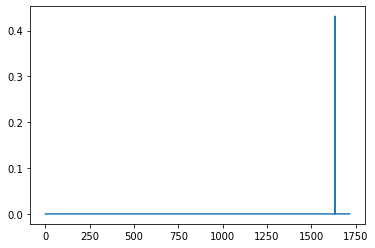

In [34]:
from rastermap import Rastermap
from scipy import stats
def running_average(X, nbin = 100):
    Y = np.cumsum(X, axis=0)
    Y = Y[nbin:, :] - Y[:-nbin, :]
    return Y

model = Rastermap(n_components=1, n_X=100).fit(ts)
isort = np.argsort(model.embedding[:,0])

# sort by embedding and smooth over neurons
Sfilt = running_average(ts[isort, :500], 50)
Sfilt = stats.zscore(Sfilt, axis=1)

nmin 200
0.30986809730529785
29.297019004821777
31.077335834503174
31.362261295318604
(98, 100)
(130,)
1.0
time; iteration;  explained PC variance
0.51s     0        0.8766      2
5.58s    10        0.9072      4
10.48s    20        0.9102      8
15.46s    30        0.9369      18
21.06s    40        0.9459      28
25.80s    50        0.9463      38
31.42s    60        0.9472      48
36.68s    70        0.9452      58
42.82s    80        0.9480      68
47.74s    90        0.9510      78
52.51s    100        0.9560      88
58.27s    110        0.9571      98
63.64s    120        0.9579      98
69.05s   final      0.9580
69.33s upsampled    0.9580


In [35]:
Sfilt = running_average(ts[isort, :], 50)
Sfilt = stats.zscore(Sfilt, axis=1)

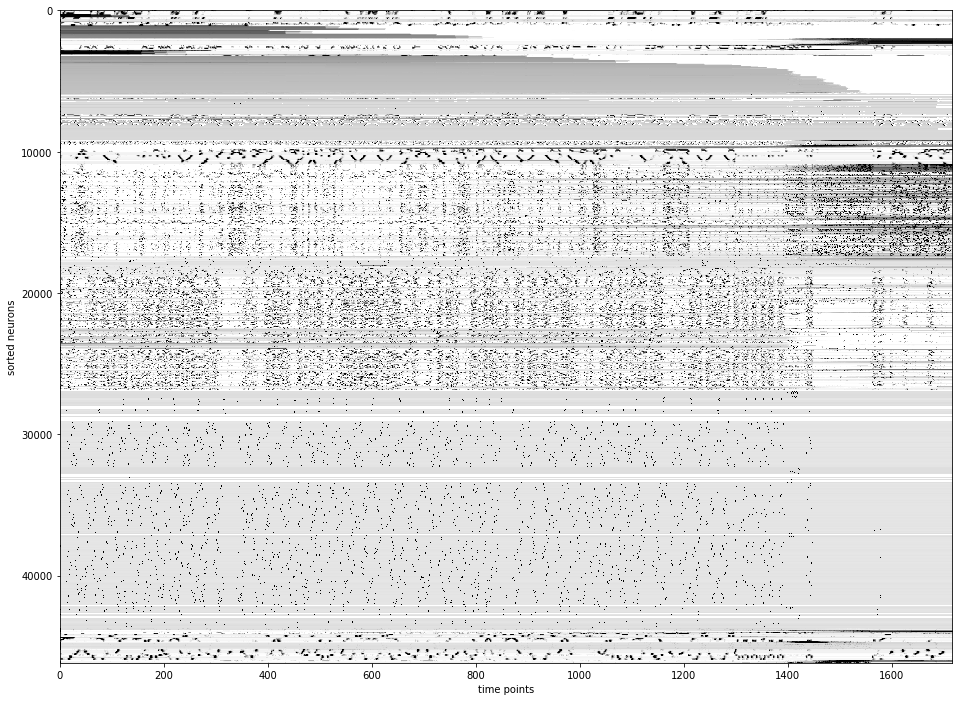

In [36]:
plt.figure(figsize=(16,12))
plt.imshow(Sfilt, vmin = -0.5, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('time points')
plt.ylabel('sorted neurons')
plt.show()

In [25]:
32*20*20

12800

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

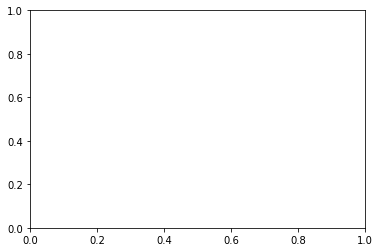

In [9]:
plt.figure() 
plt.hist(activations[0][1].flatten())
plt.show()

In [38]:
import matplotlib.pyplot as plt
for j in range(0,1000):
    plt.figure() 
    plt.imshow(activations[2][j][0,2,:,:].detach().numpy())
    plt.show()

IndexError: too many indices for tensor of dimension 3

<Figure size 432x288 with 0 Axes>

In [ ]:
for j in range(10):
    plt.imshow(activations[0][j][0,0,:,:].reshape(84,84))
    plt.show()